In [1]:
import pycuda.driver as cuda
import pycuda.autoinit  # Inicializa automaticamente o driver CUDA

# Obtém o dispositivo atual (GPU)
device = cuda.Device(0)

# Informações gerais
print("Nome da GPU:", device.name())
print("Máximo de threads por bloco:", device.get_attribute(cuda.device_attribute.MAX_THREADS_PER_BLOCK))
print("Dimensões máximas dos blocos (x, y, z):", device.get_attribute(cuda.device_attribute.MAX_BLOCK_DIM_X),
      device.get_attribute(cuda.device_attribute.MAX_BLOCK_DIM_Y),
      device.get_attribute(cuda.device_attribute.MAX_BLOCK_DIM_Z))
print("Dimensões máximas da grade (grid) (x, y, z):", device.get_attribute(cuda.device_attribute.MAX_GRID_DIM_X),
      device.get_attribute(cuda.device_attribute.MAX_GRID_DIM_Y),
      device.get_attribute(cuda.device_attribute.MAX_GRID_DIM_Z))


Nome da GPU: NVIDIA GeForce RTX 3060
Máximo de threads por bloco: 1024
Dimensões máximas dos blocos (x, y, z): 1024 1024 64
Dimensões máximas da grade (grid) (x, y, z): 2147483647 65535 65535


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [3]:
# Nome do arquivo de imagem
img_name = 'examples/2560x1440.jpg'

# Carregando a imagem com PIL
img = Image.open(img_name)

# Convertendo a imagem para escala de cinza
img_gray = img.convert("L")

In [4]:
def crop_center(arr, cropx, cropy):
    y, x = arr.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return arr[starty:starty+cropy, startx:startx+cropx]

In [5]:
# Convertendo a imagem para um array NumPy
img_arr = np.array(img_gray, dtype=float)

imgs_arr = [crop_center(img_arr, size, size).astype(np.complex64) for size in [128, 256, 512, 1024]]

C:\Users\tiago\AppData\Local\Temp\ipykernel_9876\3496436275.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.imshow(imgs_arr[3].astype(float), cmap="gray")


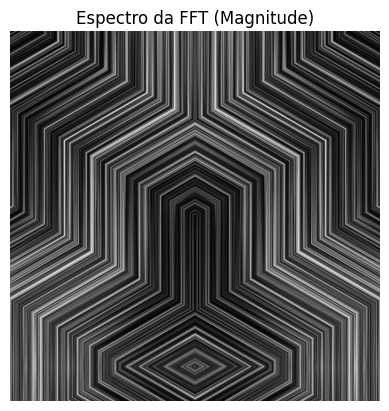

In [6]:
# Plotando o espectro de magnitude
plt.imshow(imgs_arr[3].astype(float), cmap="gray")
plt.title("Espectro da FFT (Magnitude)")
plt.axis('off')

plt.show()

In [7]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
from pycuda.compiler import SourceModule

N = imgs_arr[3].shape[0]
signal = imgs_arr[3]

mod = SourceModule("""
// Multiplicação complexa
__device__ float2 complex_mul(float2 a, float2 b) {
    return make_float2(
        a.x * b.x - a.y * b.y,
        a.x * b.y + a.y * b.x
    );
}


__device__ float2 twiddle_pos(int j, int m) {
    float theta = +2.0f * 3.14159265359f * j / m;
    return make_float2(cosf(theta), sinf(theta));
}

__device__ float2 twiddle_neg(int j, int m) {
    float theta = -2.0f * 3.14159265359f * j / m;
    return make_float2(cosf(theta), sinf(theta));
}

// Kernel serial: apenas 1 thread executando tudo
__device__ void fft_stockham_serial(float2 *src, float2 *dst, int N) {
    __syncthreads();

    int stages = 0;

    int n = N;

    while (n > 1) {
        n /= 2;
        stages++;
    }

    for (int stage = 0; stage < stages; stage++) {
        int m = 1 << (stage + 1);
        int half_m = m / 2;

        for (int idx = 0; idx < N / 2; idx++) {
            int group = idx / half_m;
            int j = idx % half_m;

            int src_idx_l = idx;
            int src_idx_r = idx + N / 2;

            float2 w = twiddle_neg(j, m);
            float2 a = src[src_idx_l];
            float2 b = complex_mul(w, src[src_idx_r]);

            dst[group * m + j] = make_float2(a.x + b.x, a.y + b.y);
            dst[group * m + j + half_m] = make_float2(a.x - b.x, a.y - b.y);
        }

        for (int i = 0; i < N; i++) {
            src[i] = dst[i];
        }
    }
}

__device__ void ifft_stockham_serial(float2 *src, float2 *dst, int N) {
    __syncthreads();

    int stages = 0;

    int n = N;

    while (n > 1) {
        n /= 2;
        stages++;
    }

    for (int stage = 0; stage < stages; stage++) {
        int m = 1 << (stage + 1);
        int half_m = m / 2;

        for (int idx = 0; idx < N / 2; idx++) {
            int group = idx / half_m;
            int j = idx % half_m;

            int src_idx_l = idx;
            int src_idx_r = idx + N / 2;

            float2 w = twiddle_pos(j, m);
            float2 a = src[src_idx_l];
            float2 b = complex_mul(w, src[src_idx_r]);

            dst[group * m + j] = make_float2(a.x + b.x, a.y + b.y);
            dst[group * m + j + half_m] = make_float2(a.x - b.x, a.y - b.y);
        }

        for (int i = 0; i < N; i++) {
            src[i] = dst[i];
        }
    }

    for (int i = 0; i < N; i++) {
        src[i].x /= N;
        src[i].y /= N;
    }
}

__device__ void transpose(float2 *input, int size, int tid) {
    if (tid >= size) return;
    for (int i = tid + 1; i < size; i++) {
        float2 temp = input[tid * size + i];
        input[tid * size + i] = input[i * size + tid];
        input[i * size + tid] = temp;
    }
}

__global__ void fft2_stockham(float2 *src, float2 *dst, int N) {
    int tid = threadIdx.x + blockDim.x * blockIdx.x;

    fft_stockham_serial(&src[tid * N], &dst[tid * N], N);

    __syncthreads();

    transpose(src, N, tid);

    __syncthreads();

    fft_stockham_serial(&src[tid * N], &dst[tid * N], N);

    __syncthreads();

    transpose(src, N, tid);
}

__global__ void ifft2_stockham(float2 *src, float2 *dst, int N) {
    int tid = threadIdx.x + blockDim.x * blockIdx.x;

    transpose(src, N, tid);
                   
    __syncthreads();

    ifft_stockham_serial(&src[tid * N], &dst[tid * N], N);

    __syncthreads();

    transpose(src, N, tid);

    __syncthreads();

    ifft_stockham_serial(&src[tid * N], &dst[tid * N], N);
}
""")

In [8]:
src_gpu = cuda.mem_alloc(signal.nbytes)
dst_gpu = cuda.mem_alloc(signal.nbytes)

cuda.memcpy_htod(src_gpu, signal)

stockham_serial = mod.get_function("fft2_stockham")
stockham_serial(src_gpu, dst_gpu, np.int32(N), block=(N, 1, 1), grid=(1, 1))

result = np.empty_like(signal)

cuda.memcpy_dtoh(result, src_gpu)

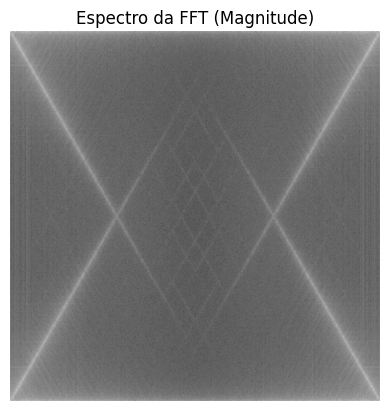

In [9]:
magnitude_spectrum = 20 * np.log(np.abs(result) + 1)

plt.imshow(magnitude_spectrum, cmap="gray")
plt.title("Espectro da FFT (Magnitude)")
plt.axis('off')

plt.show()

In [10]:
src_gpu = cuda.mem_alloc(signal.nbytes)
dst_gpu = cuda.mem_alloc(signal.nbytes)

cuda.memcpy_htod(src_gpu, result)

stockham_serial = mod.get_function("ifft2_stockham")
stockham_serial(src_gpu, dst_gpu, np.int32(N), block=(N, 1, 1), grid=(1, 1))

result = np.empty_like(signal)

cuda.memcpy_dtoh(result, src_gpu)

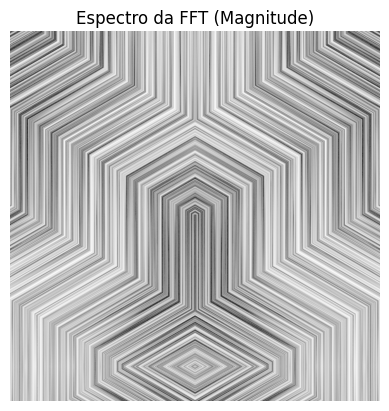

In [11]:
magnitude_spectrum = 20 * np.log(np.abs(result) + 1)

plt.imshow(magnitude_spectrum, cmap="gray")
plt.title("Espectro da FFT (Magnitude)")
plt.axis('off')

plt.show()

# Banchmark

In [12]:
import time

def fft_exec_time(array):
    start = time.time()
    src_gpu = cuda.mem_alloc(array.nbytes)
    dst_gpu = cuda.mem_alloc(array.nbytes)

    cuda.memcpy_htod(src_gpu, array)

    stockham_serial = mod.get_function("fft2_stockham")
    stockham_serial(src_gpu, dst_gpu, np.int32(array.shape[0]), block=(array.shape[0], 1, 1), grid=(1, 1))

    result = np.empty_like(array)

    cuda.memcpy_dtoh(result, src_gpu)

    return time.time() - start, result

In [13]:
fft_results = [fft_exec_time(img) for img in imgs_arr]

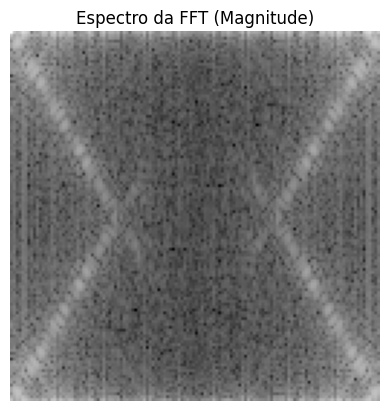

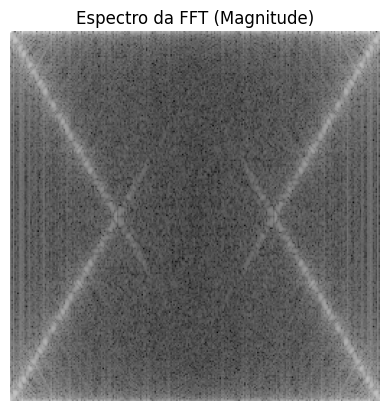

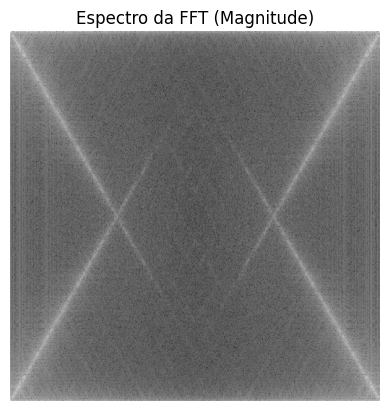

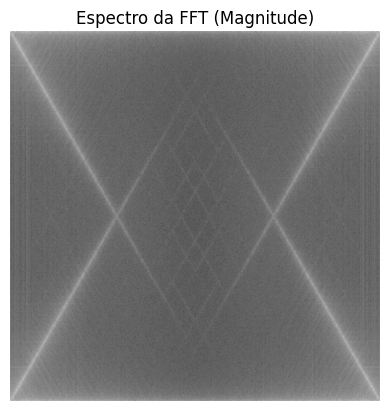

In [14]:
for time, img in fft_results:
    magnitude_spectrum = 20 * np.log(np.abs(img) + 1)

    plt.imshow(magnitude_spectrum, cmap="gray")
    plt.title("Espectro da FFT (Magnitude)")
    plt.axis('off')

    plt.show()

In [15]:
fft_times = [time * 1000 for time, _ in fft_results]

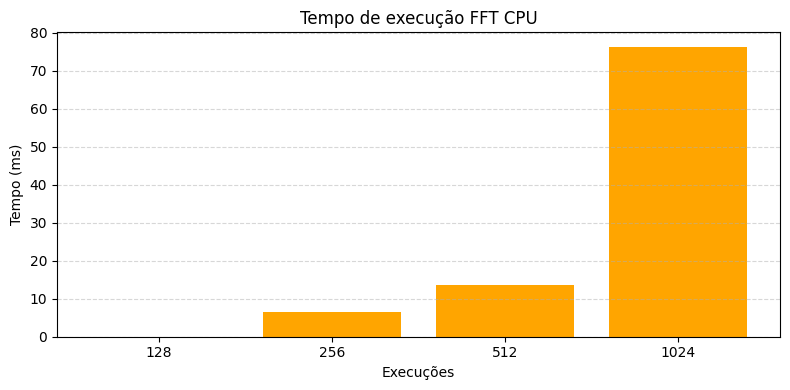

In [16]:
plt.figure(figsize=(8, 4))
plt.bar(["128", "256", "512", "1024"], fft_times, color='orange')
plt.xlabel("Execuções")
plt.ylabel("Tempo (ms)")
plt.title("Tempo de execução FFT CPU")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("banchmark/fft_gpu.png")
plt.show()